# Colour Law

In this notebook, I study the colour law obtained with PISCOLA, compare it with SALT2, and check for evidence of evolution as a function of phase.

In [1]:
import pandas as pd
import numpy as np
import scipy
import emcee

import piscola
import sncosmo  # to estimate SALT2 colour law

from extinction import ccm89, fitzpatrick99, odonnell94

# plotting
import matplotlib.pyplot as plt
from matplotlib import cm, colors

%config InlineBackend.figure_format = 'retina'
plt.rcParams["font.family"] = "Gentium"
plt.rcParams['mathtext.fontset'] = "cm"

print(f'piscola v{piscola.__version__}')

#-------------------------------------------------------------

COLOUR_OFFSET = 0.0267716  # base SALT2 template (B-V) colour
WAVE = np.arange(2800, 7000, 5.)  # wavelegnth range to use throughout
B_WAVE = 4400.0
V_WAVE = 5500.0
REF_WAVE = B_WAVE  # for plotting and analysis purposes
EXT_LAW = 'fitzpatrick99'

FORMAT = 'pdf'  # for image output

# Fit results
pisco_df = pd.read_csv('piscola_results.csv')

piscola v0.1.7


In [2]:
def extinction_function(wave, extinction_law='fitzpatrick99', AV=1.0, RV=3.1):
    '''Calculates the dust extinction law.
    
    Note: AV = E(B-V)*RV
    
    Parameters
    ----------
    wave: array
        wavelengths.
    extinction_law: str, default 'fitzpatrick99'
        dust extinction law (ccm89, odonnell94 or fitzpatrick99).
    AV: float
        V-band extinction in magnitudes.
    RV: float, default '3.1'
        total-to-selective extinction.
        
    Returns
    -------
    A_lambda: arrays
        extinction as a function of wavelegnth.
    '''
    
    extinction_law = eval(extinction_law)
    A_lambda = extinction_law(wave, AV, RV)
    
    return A_lambda

def calc_salt2_cl():
    '''Calculates the SALT2 colour law and colour dispersion.
    
    Note: this is calculated using the sncosmo package.
    
    Returns
    -------
    salt2_wave: arrays
        wavelegnths of the colour law.
    salt2_cl: arrays
        SALT2 colour law values.
    salt2_colour_disp: arrays
        SALT2 colour dispersion.
        
    '''
    
    file = open('salt2_color_correction.dat', 'r')
    text = file.read().split()
    file.close()

    # Get color law coeffecients.
    ncoeffs = int(text[0])
    colorlaw_coeffs = [float(word) for word in text[1: 1 + ncoeffs]]

    min_lambda = float(text[-3])
    max_lambda = float(text[-1])
    colorlaw_range = [min_lambda, max_lambda]
    salt2_cl_estimator = sncosmo.salt2utils.SALT2ColorLaw(colorlaw_range, colorlaw_coeffs)
    
    salt2_wave = np.arange(min_lambda, max_lambda, 5.)
    salt2_cl = salt2_cl_estimator(salt2_wave)
    
    # colour dispersion
    salt2_disp_wave, salt2_colour_disp = np.loadtxt('salt2_color_dispersion_jla_b14.dat').T
    salt2_colour_disp = np.interp(WAVE, salt2_disp_wave, salt2_colour_disp)
    
    return salt2_wave, salt2_cl, salt2_colour_disp

def extract_mangling_funtion(pisco_df, mangling_phases):
    ''' Extracts the SNe mangling function at the given phases.
    
    Parameters
    ----------
    pisco_df: DataFrame
        Dataframe with the PISCOLA parameters.
    mangling_phases: array-like
        Phases at which the mangling function is extracted.
        
    Returns
    -------
    mangling_function_dict: dict
        Dictionary with mangling functions at different phases.
    '''
    
    mangling_function_dict = {phase:[] for phase in mangling_phases}
    
    for sn_name in pisco_df.name:
        sn = piscola.load_sn(sn_name, path='output')
        for phase in mangling_phases:
            if phase in sn.mangling_results.keys():
                mangling_function_dict[phase].append(sn.mangling_results[phase]['mangling_function'])
            else:
                mangling_function_dict[phase].append(np.nan)
    
    return mangling_function_dict

def multi_residuals(coefs, wave, cl_list, dispersion_list, colour_range, mask_list):
    """Function to minimise for obtaining a functional form for the PISCOLA colour law.
    A single, "universal" colour law is estimated for all the colours given.
    
    Parameters
    ----------
    coefs: array-like
        coefficients of the polynomial.
    wave: array
        wavelengths where the colour law is estimated.
    cl_list: list
        list of colour laws.
    dispersion_list: list
        list of colour dispersions.
    colour_range: array-like
        colours for which the colour law is estimated.
    mask_list: list
        list of masks applied to the different colour laws.
        
    Returns
    -------
    chisq_sum: float
        Sum of multiple residuals, given by the colour range.
    """
    
    chisq_list = []
    for cl, dispersion, colour, mask in zip(cl_list, dispersion_list, colour_range, mask_list):
        poly = np.poly1d(coefs)
        cl_model = colour*poly(wave[mask])

        # calculate chi²
        residual = cl - cl_model
        chisq = np.sum((residual/dispersion)**2)  
        chisq_list.append(chisq)
    
    chisq_sum = np.sum(np.array(chisq_list))
    
    return chisq_sum

def extinction_residual(rv, y, ext_law, colour, sigma=1):
    """Simple Chi^2 residual to fit an extinction law.
    
    Parameters
    ----------
    RV: float
        total-to-selective extinction.
    y: array
        PISCOLA colour law times colour.
    cl_list: list
        list of colour laws.
    ext_law: str
        extinction law.
    colour: float
        (B-V) colour.
    sigma: array or float, default `1`
        uncertainty in the PISCOLA extinction law.
        
    Returns
    -------
    chi_sq: float
        Chi^2 value.
    """
    
    AV = colour*rv
    A_lambda = extinction_function(WAVE, ext_law, AV, rv)
    A_ref = extinction_function(np.array([REF_WAVE]), ext_law, AV, rv)
    y_model = A_lambda-A_ref

    y_diff = y-y_model
    chi_sq = np.sum((y_diff/sigma)**2)
    
    return chi_sq

def line(x, m, b):
    """Simple straight line function with slope "m" and intercept "b".
    """
    
    y = m*x + b
    
    return y

## SALT2 Colour Law

Let's plot the SALT2 colour law and a dust extinction function to make sure everything looks correct.

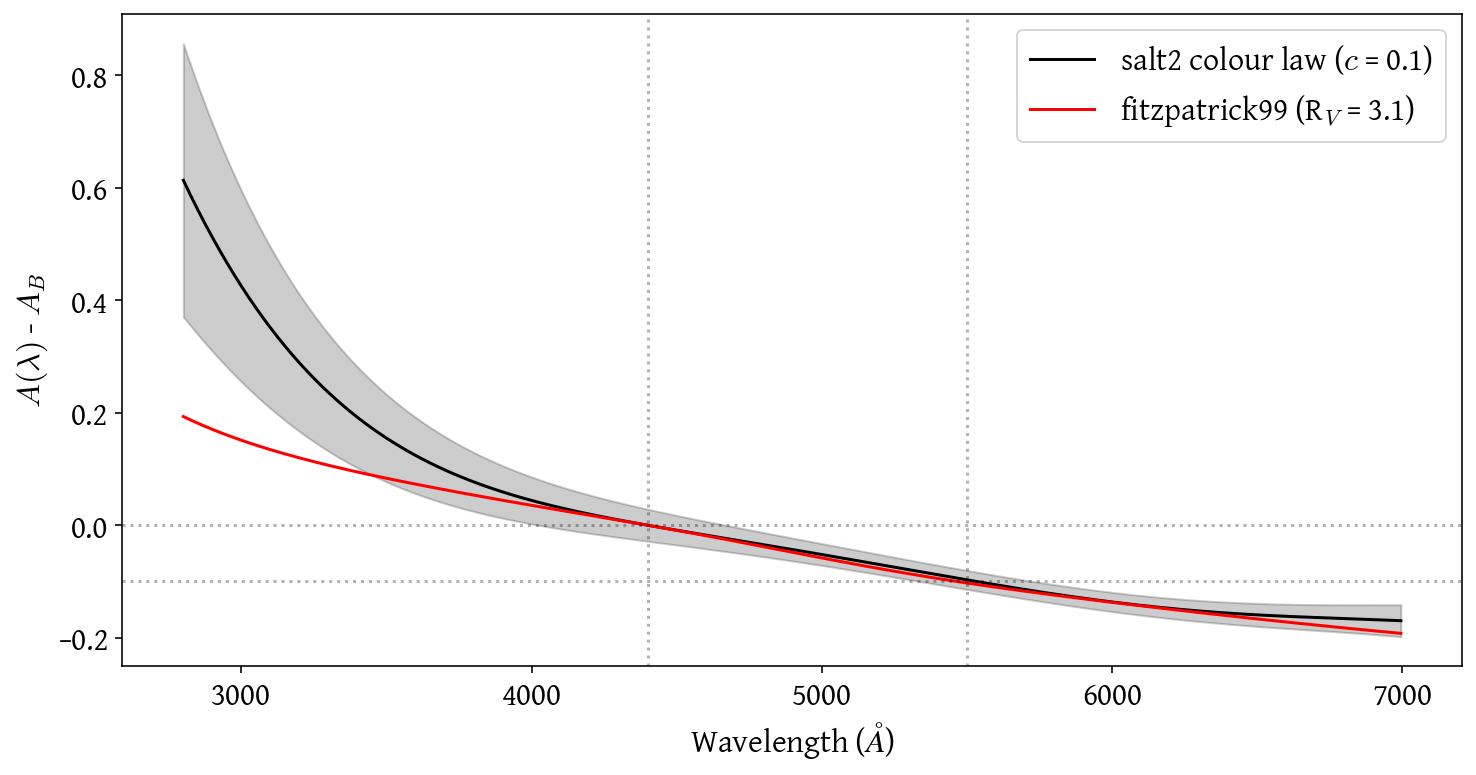

In [3]:
c = 0.1  # SALT2 colour

# extinction
RV = 3.1
AV = c*RV

A_lambda = extinction_function(WAVE, EXT_LAW, AV, RV)
A_ref = extinction_function(np.array([REF_WAVE]), EXT_LAW, AV, RV)

# colour law
salt2_wave, salt2_cl, salt2_colour_disp = calc_salt2_cl()
salt2_id = np.argmin(np.abs(WAVE-REF_WAVE))
salt2_ref = salt2_cl[salt2_id]

salt2_cl_colour = (salt2_cl-salt2_ref)*c
cl_ymin, cl_ymax = salt2_cl_colour - salt2_colour_disp, salt2_cl_colour + salt2_colour_disp

#---------------------------------------------
# plotting

fig, ax = plt.subplots(figsize=(12, 6))

# colour law
ax.plot(WAVE, salt2_cl_colour, label=f'salt2 colour law ($c$ = {c})', color='k')
ax.fill_between(WAVE, cl_ymin, cl_ymax, alpha=0.2, color='k')

# extintion
ax.plot(WAVE, A_lambda-A_ref, label=f'{EXT_LAW} (R$_V$ = 3.1)', color='r')

ax.axhline(0, ls='dotted', color='k', alpha=0.3)
ax.axhline(-c, ls='dotted', color='k', alpha=0.3)
ax.axvline(B_WAVE, ls='dotted', color='k', alpha=0.3)
ax.axvline(V_WAVE, ls='dotted', color='k', alpha=0.3)

ax.set_xlabel('Wavelength ($\AA$)', fontsize=16)
ax.set_ylabel(f'$A(\lambda)$ - $A_B$', fontsize=16)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16)
plt.show()

___
## PISCOLA Colour Law

We need to extract the mangling functions for the SN sample.

In [4]:
mangling_phases = np.arange(-10, 11, 1)
mangling_function_dict = extract_mangling_funtion(pisco_df, mangling_phases)

We can plot the colour distribution to see what range we can play around with.

<AxesSubplot:>

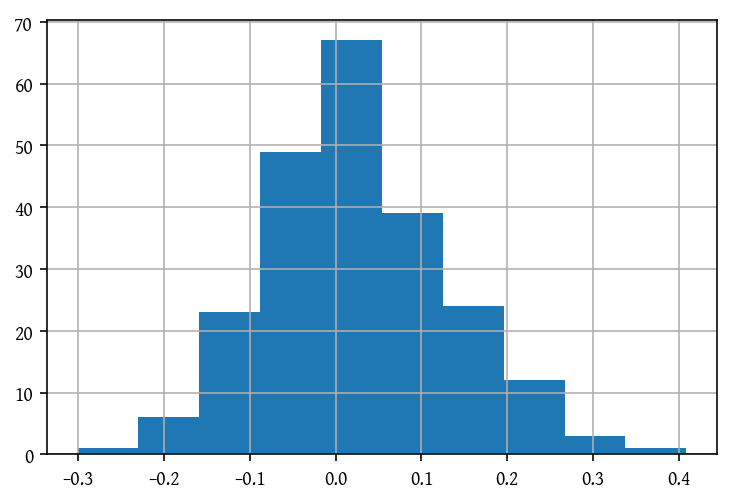

In [5]:
pisco_df.colour.hist()

I will use tha range from -0.20 mag to 0.25 mag.

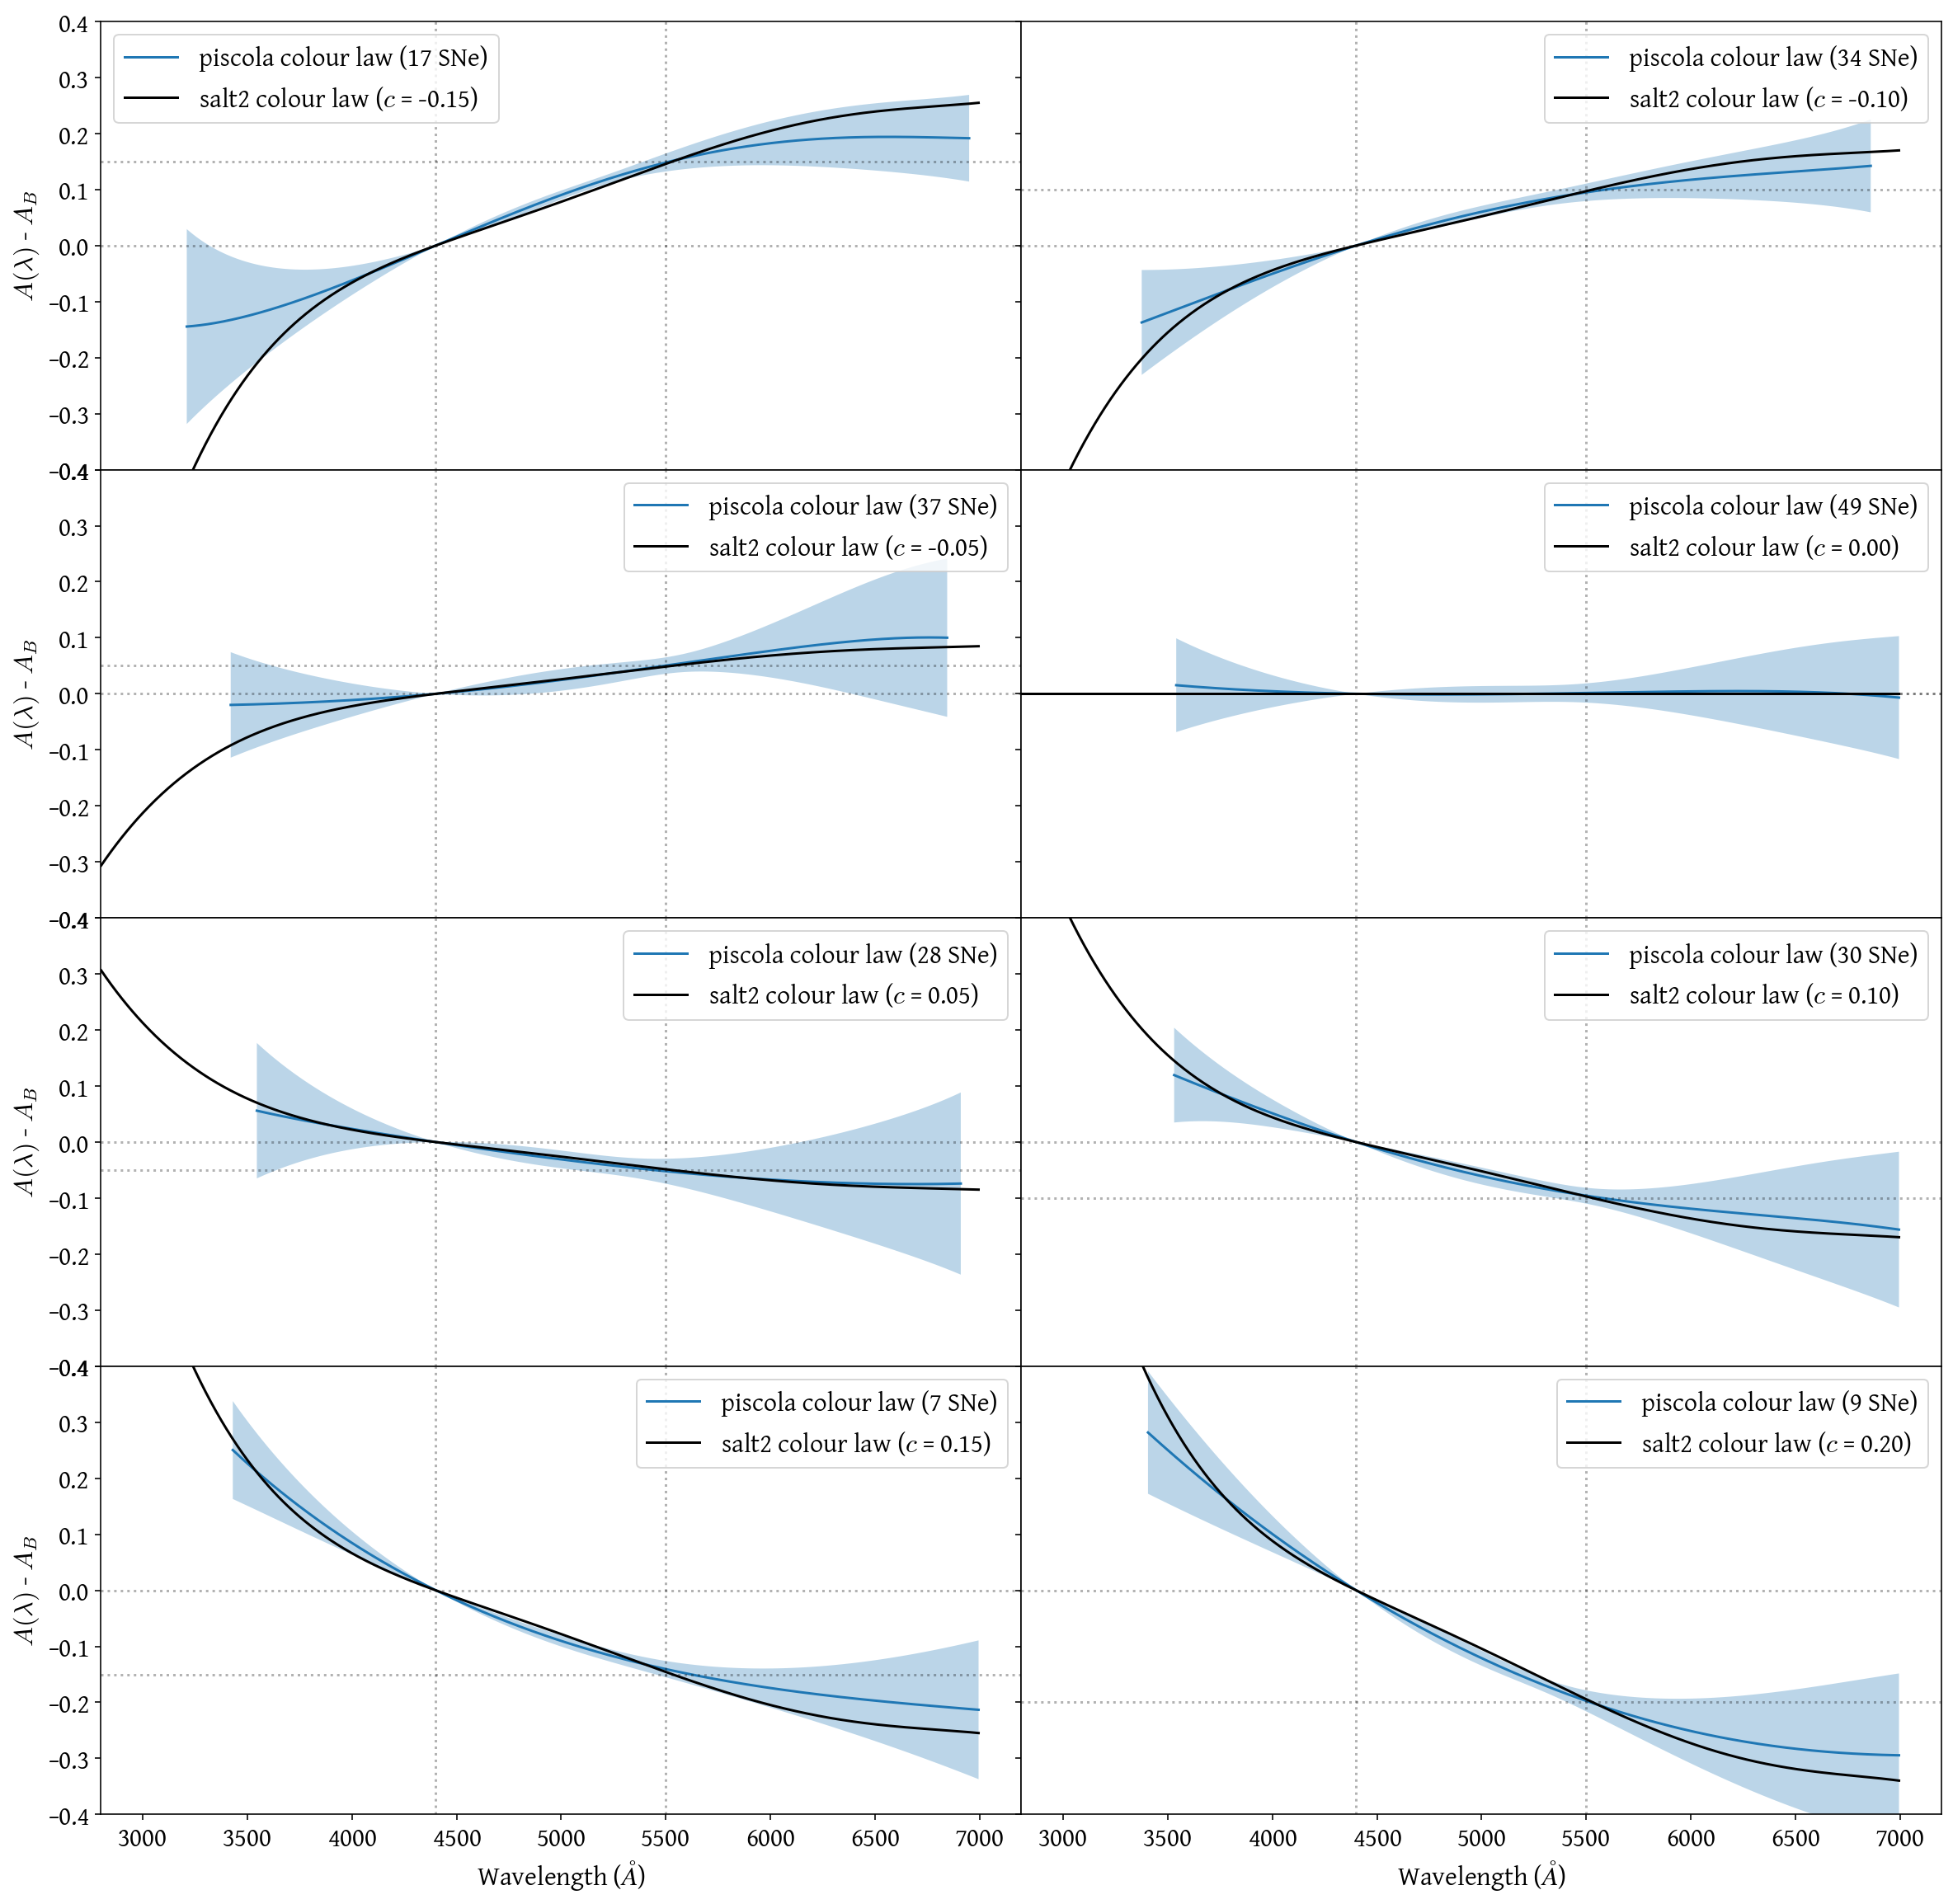

In [17]:
cl_list, dispersion_list, mask_list = [], [], []
step = 0.05
colour_range = np.arange(-0.15, 0.20+step, step)

# mangling function at peak
mangling_function_list = mangling_function_dict[0] 

n_rows = len(colour_range)//2 + len(colour_range)%2

fig, ax = plt.subplots(n_rows, 2, figsize=(20, 5*n_rows), 
                           sharex=True, sharey=True, gridspec_kw={'hspace':0, 'wspace':0})

for i, colour in enumerate(colour_range):
    sample_cl = []
    for mangling_function, sn_colour, z in zip(mangling_function_list, pisco_df['colour'], pisco_df['z']):

        # Check SNe with similar colours between piscola, (B-V), and salt2, c.
        # The salt2 template has an intrinsic (B-V) colour different from 0.0, which must be subtracted
        if np.abs((sn_colour-COLOUR_OFFSET) - colour) < 0.025:
            pisco_wave, flux_ratio = mangling_function['waves']/(1+z), mangling_function['flux_ratios']
            pisco_cl = -2.5*np.log10(flux_ratio) 

            ref_id = np.argmin(np.abs(pisco_wave - REF_WAVE))
            pisco_ref = pisco_cl[ref_id]

            # use the same wavelength grid as everywhere
            pisco_cl = np.interp(WAVE, pisco_wave, pisco_cl - pisco_ref, left=-99, right=-99)
            pisco_cl[pisco_cl==-99]=np.nan

            sample_cl.append(pisco_cl)
            
    # calculate average colour law and colour dispersion
    sample_cl = np.array(sample_cl)
    cl_mask = ~np.isnan(sample_cl).any(axis=0)  # remove wavelengths with any missing value from any SN
    #cl_mask = ~np.isnan(sample_cl).all(axis=0)
    sample_cl = sample_cl.T[cl_mask].T
    mean_cl, std_cl = np.nanmean(sample_cl, axis=0), np.nanstd(sample_cl, axis=0)

    # colour law values to estimate a functional form later
    cl_list.append(mean_cl)
    dispersion_list.append(std_cl)
    mask_list.append(cl_mask)
    
    #------------------------------
    # plotting
    i0, i1 = i//2, i%2
    
    # piscola colour law
    ax[i0, i1].plot(WAVE[cl_mask], mean_cl, label=f'piscola colour law ({sample_cl.shape[0]} SNe)')
    ax[i0, i1].fill_between(WAVE[cl_mask], mean_cl-std_cl, mean_cl+std_cl, alpha=0.3)

    # salt2 colour law
    ax[i0, i1].plot(WAVE, (salt2_cl-salt2_ref)*colour, 
                                label=f'salt2 colour law ($c$ = {colour:.2f})', color='k')

    ax[i0, i1].axhline(0, ls='dotted', color='k', alpha=0.3)
    ax[i0, i1].axhline(-colour, ls='dotted', color='k', alpha=0.3)
    ax[i0, i1].axvline(B_WAVE, ls='dotted', color='k', alpha=0.3)
    ax[i0, i1].axvline(V_WAVE, ls='dotted', color='k', alpha=0.3) 
    
    ax[i0, i1].set_xlabel('Wavelength ($\AA$)', fontsize=16)
    if i1==0:
        ax[i0, i1].set_ylabel(f'$A(\lambda)$ - $A_B$', fontsize=16)
    ax[i0, i1].set_xlim(2800, 7200)
    ax[i0, i1].set_ylim(-0.4, 0.4)
    ax[i0, i1].tick_params(labelsize=16)
    ax[i0, i1].legend(fontsize=16)

#plt.savefig(f'plots/colour_law_set.{FORMAT}', bbox_inches='tight')
plt.show()

It seems like PISCOLA retrieves a similar colour law to that used by SALT2.

___
### Functional form for the colour law

I will fit a 3rd degree polynomial to the mangling functions to estimate the colour law, in a similar fashion SALT2 does.

polynomial coefficients: [-3.75719767e-12  2.99935955e-07 -3.57255080e-03  1.02328207e+01]


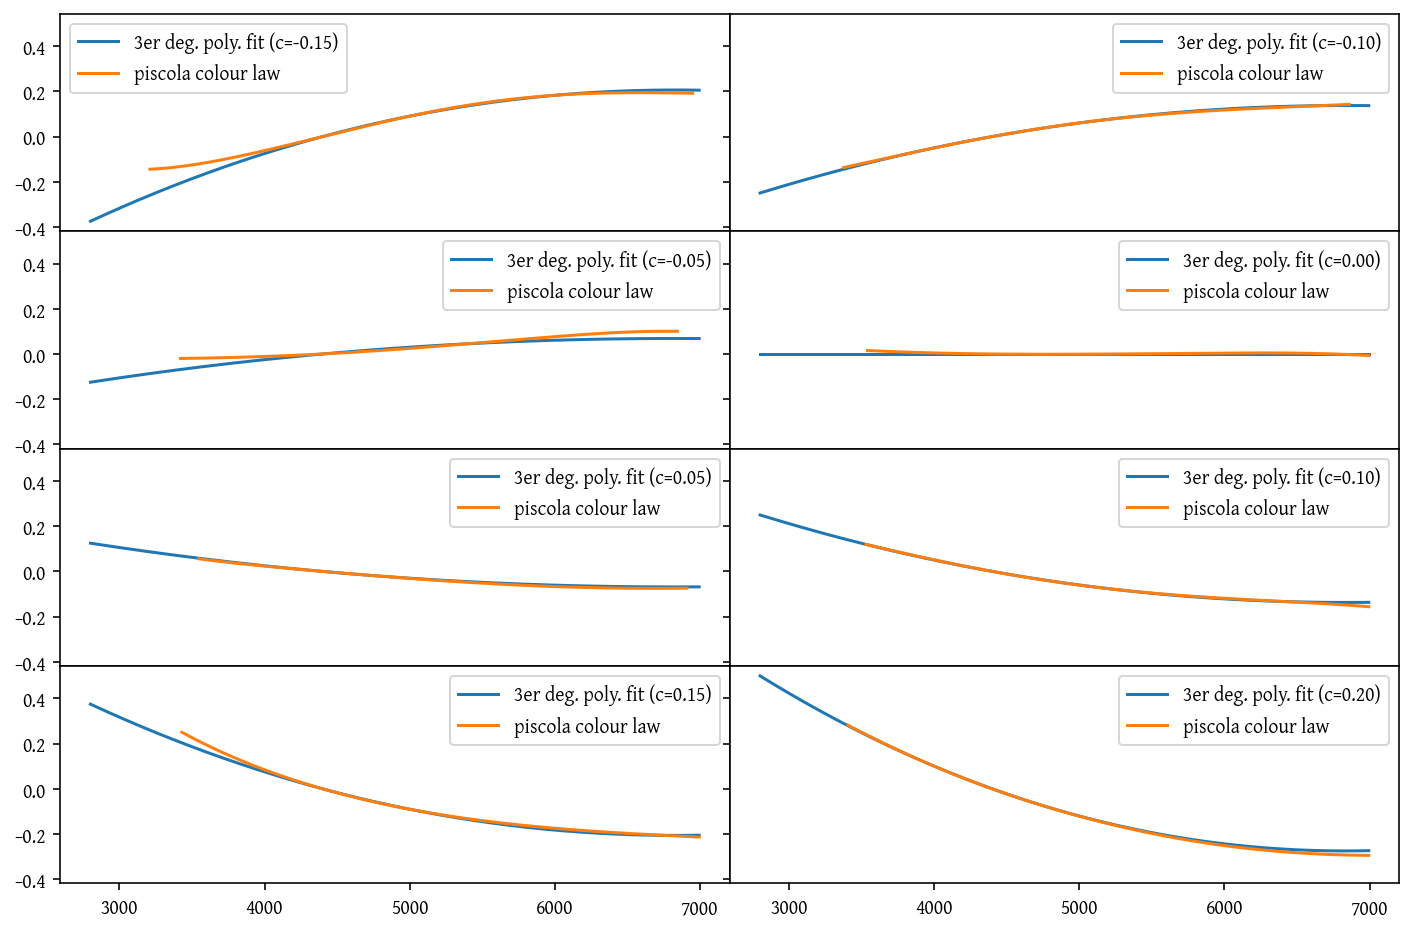

In [18]:
p0 = np.array([-3.75719767e-12,  8.27656181e-08, -6.26422659e-04,  1.47319867e+00])

res = scipy.optimize.minimize(multi_residuals, p0, args=(WAVE, cl_list, dispersion_list, 
                                                         colour_range, mask_list), method='Powell', tol=1e-20)
cl_coefs = res.x
print(f'polynomial coefficients: {cl_coefs}')

poly = np.poly1d(cl_coefs)

# plotting
fig, ax = plt.subplots(n_rows, 2, figsize=(12, 2*n_rows), 
                          sharex=True, sharey=True, gridspec_kw={'hspace':0, 'wspace':0})
    
for i, (cl, colour, mask) in enumerate(zip(cl_list, colour_range, mask_list)):
    i0, i1 = i//2, i%2
    
    ax[i0, i1].plot(WAVE, colour*poly(WAVE), label=f'3er deg. poly. fit (c={colour:.2f})')
    ax[i0, i1].plot(WAVE[mask], cl, label='piscola colour law')
    ax[i0, i1].legend()
plt.show()

In [19]:
def log_likelihood(coefs, wave, cl_list, dispersion_list, colour_range, mask_list):
    
    chisq_list = []
    for cl, dispersion, colour, mask in zip(cl_list, dispersion_list, colour_range, mask_list):
        poly = np.poly1d(coefs)
        cl_model = colour*poly(wave[mask])

        # calculate chi²
        residual = cl - cl_model
        sigma2 = dispersion**2
        log_chi = -0.5 * np.sum(residual** 2 / sigma2 + np.log(sigma2))
        chisq_list.append(log_chi)
    
    chisq_sum = np.sum(np.array(chisq_list))
    
    return chisq_sum

def log_prior(coefs):
    
    if all(coefs<5) and all(coefs>-5):
        return 0.0
    return -np.inf

def log_probability(coefs, wave, cl_list, dispersion_list, colour_range, mask_list):
    lp = log_prior(coefs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(coefs, wave, cl_list, dispersion_list, colour_range, mask_list)

In [20]:
pos = np.array([0, 0, -4e-4, 5]) + 1e-4 * np.random.randn(32, len(cl_coefs))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(WAVE, cl_list, dispersion_list, colour_range, mask_list)
)
sampler.run_mcmc(pos, 1000, progress=True);

  0%|                                                                                                                                                                                                                                                                                       | 0/1000 [00:00<?, ?it/s]/home/tomas/anaconda3/envs/colour_law/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 43.66it/s]


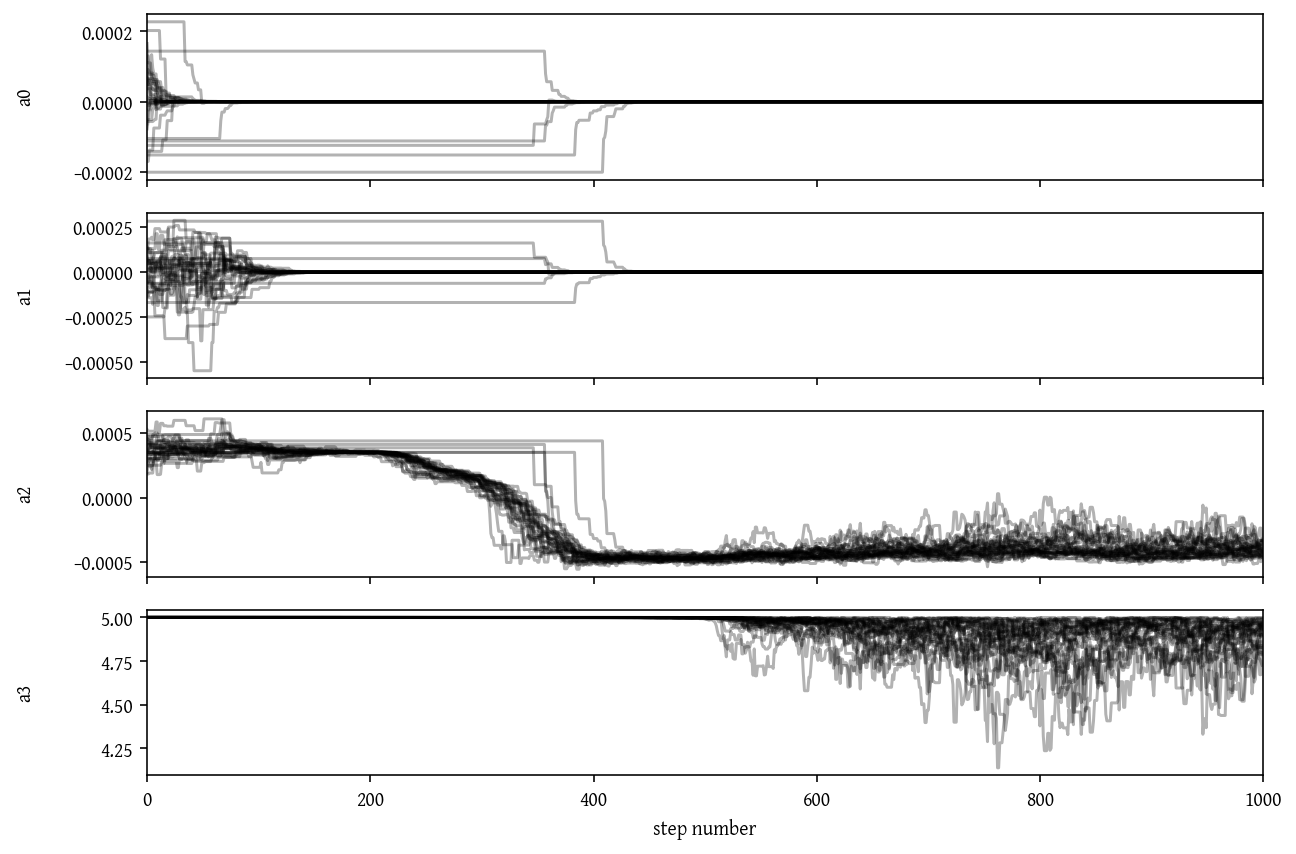

In [21]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a"+str(i) for i in range(ndim)]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

3.635426543839836e-11 1.1020486431220834e-12 1.1245901913501064e-12
-3.1785112006047634e-07 1.4472019913872544e-08 1.1627184408954185e-08
-0.0004320596490902806 3.7005922387396174e-05 6.494761339193673e-05
4.960566594154885 0.12146920213889345 0.03811102895733587


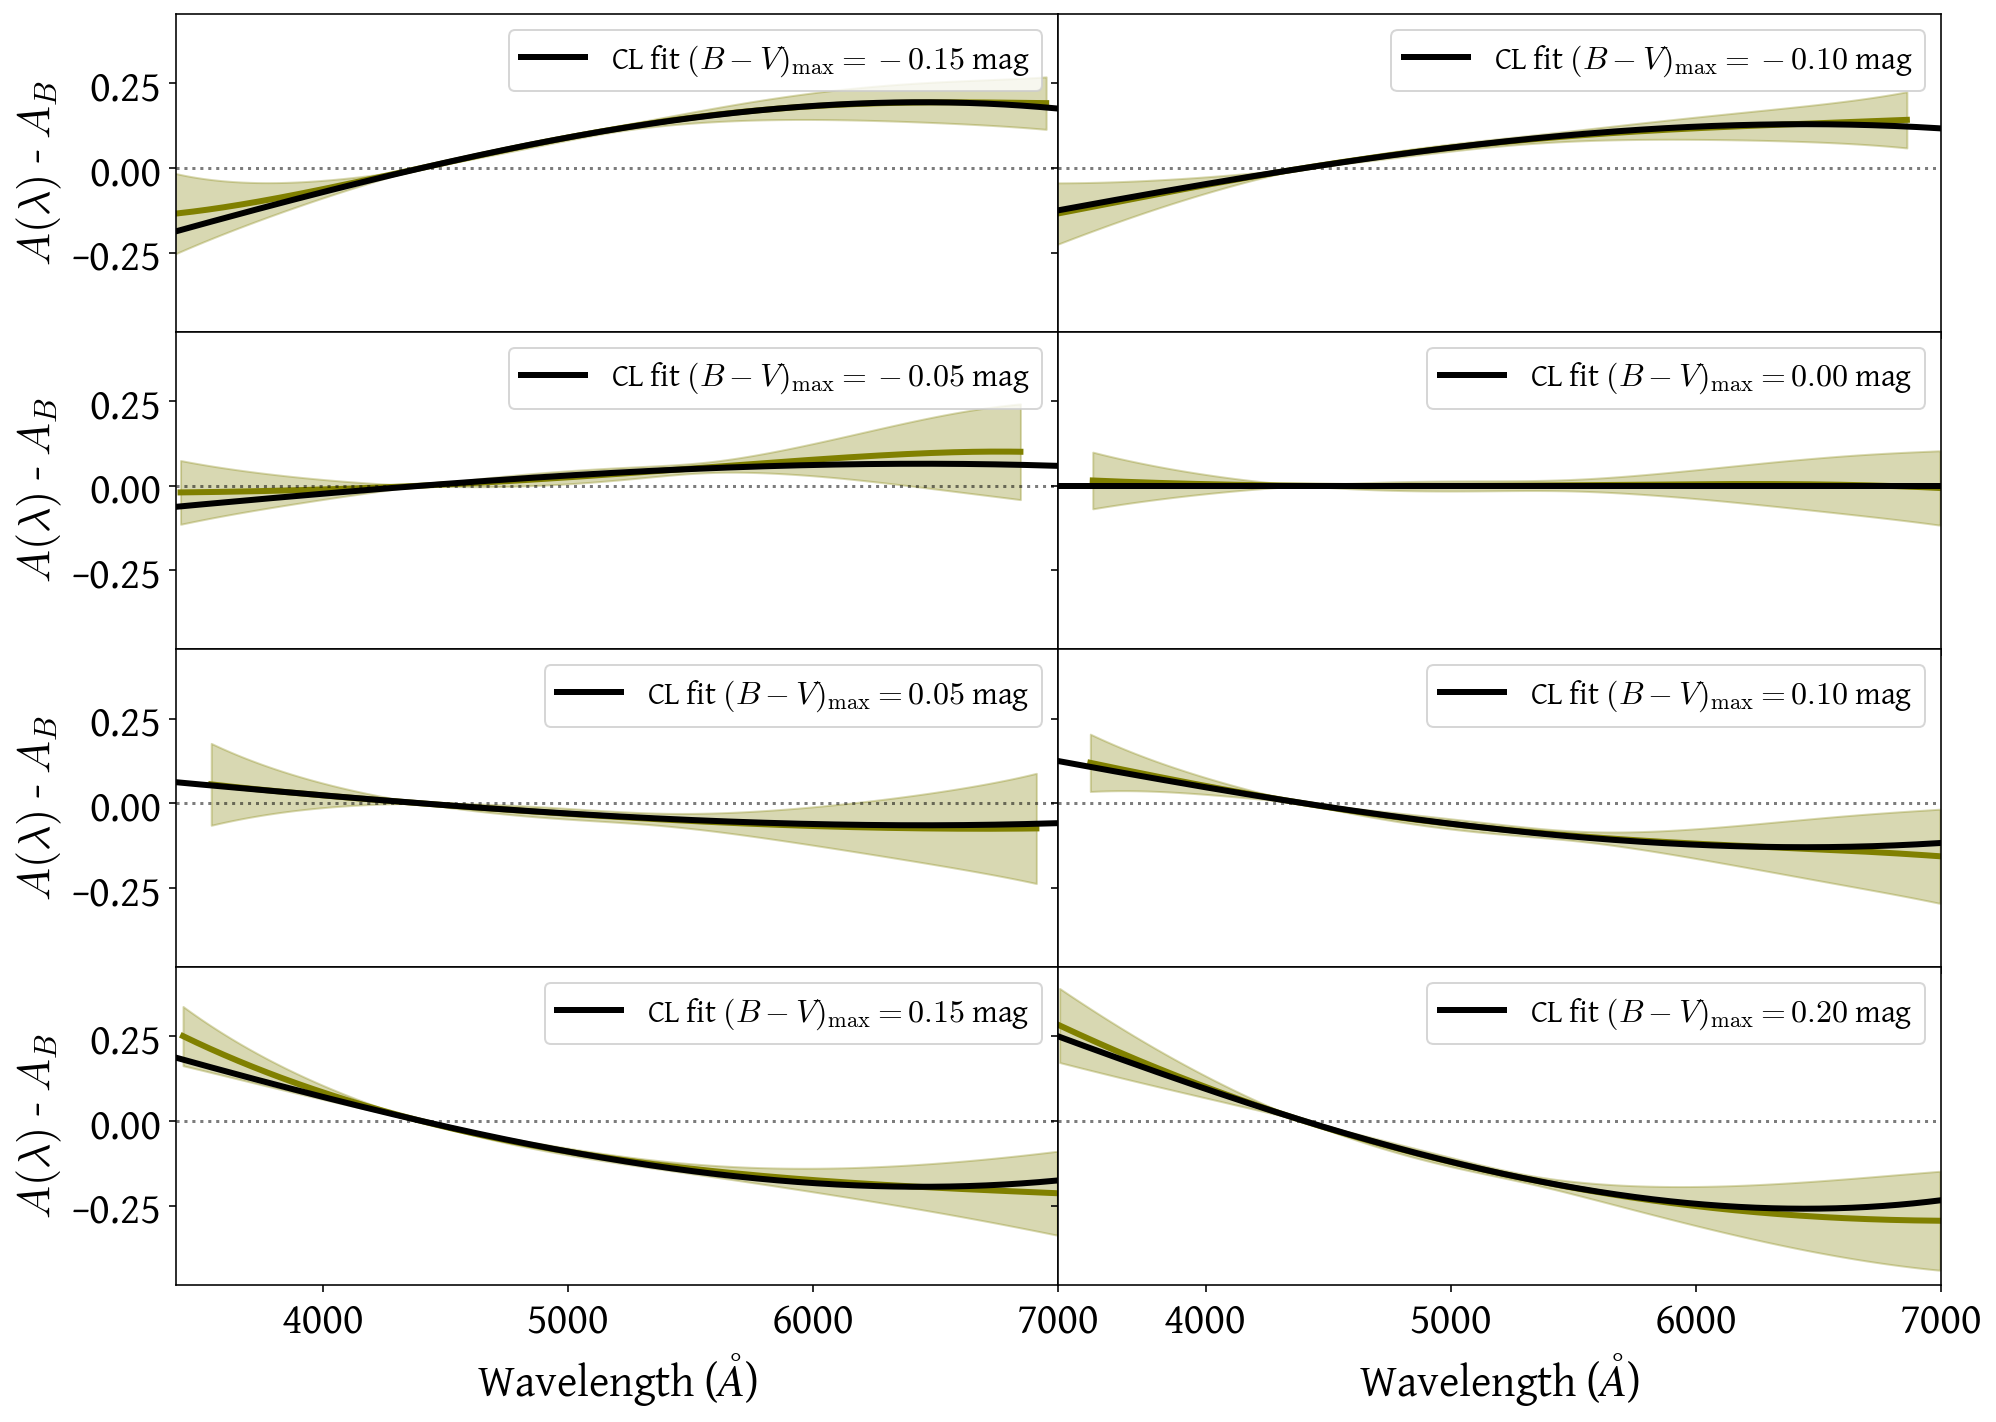

In [48]:
flat_samples = sampler.get_chain(discard=400, thin=15, flat=True)

mcmc_coefs = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    mcmc_coefs.append(mcmc[1])
    print(mcmc[1], q[0], q[1])
    
####
poly = np.poly1d(mcmc_coefs)

fig, ax = plt.subplots(n_rows, 2, figsize=(14, 2.5*n_rows), 
                          sharex=True, sharey=True, gridspec_kw={'hspace':0, 'wspace':0})
    
for i, (cl, dispersion, colour, mask) in enumerate(zip(cl_list, dispersion_list, colour_range, mask_list)):
    i0, i1 = i//2, i%2
    
    ax[i0, i1].plot(WAVE[mask], cl, lw=3, color='olive')
    ax[i0, i1].fill_between(WAVE[mask], cl-dispersion, cl+dispersion, color='olive', alpha=0.3)
    ax[i0, i1].plot(WAVE, colour*poly(WAVE), lw=3, color='k', label=r'CL fit $(B-V)_{\rm max}=%.2f$ mag'%colour)
    
    ax[i0, i1].set_xlim(3400, 7000)
    ax[i0, i1].tick_params(labelsize=22)
    ax[i0, i1].legend(fontsize=16)
    ax[i0, 0].set_ylabel(f'$A(\lambda)$ - $A_B$', fontsize=22)
    ax[i0, 0].axhline(0, ls='dotted', color='k', alpha=0.3)
    ax[i0, 1].axhline(0, ls='dotted', color='k', alpha=0.3)
    
ax[-1, 0].set_xlabel('Wavelength ($\AA$)', fontsize=22)
ax[-1, 1].set_xlabel('Wavelength ($\AA$)', fontsize=22)
fig.tight_layout()
fig.savefig('plots/cl_fits.pdf')
plt.show()

The polynomial fit looks quite good for the entire colour range used.

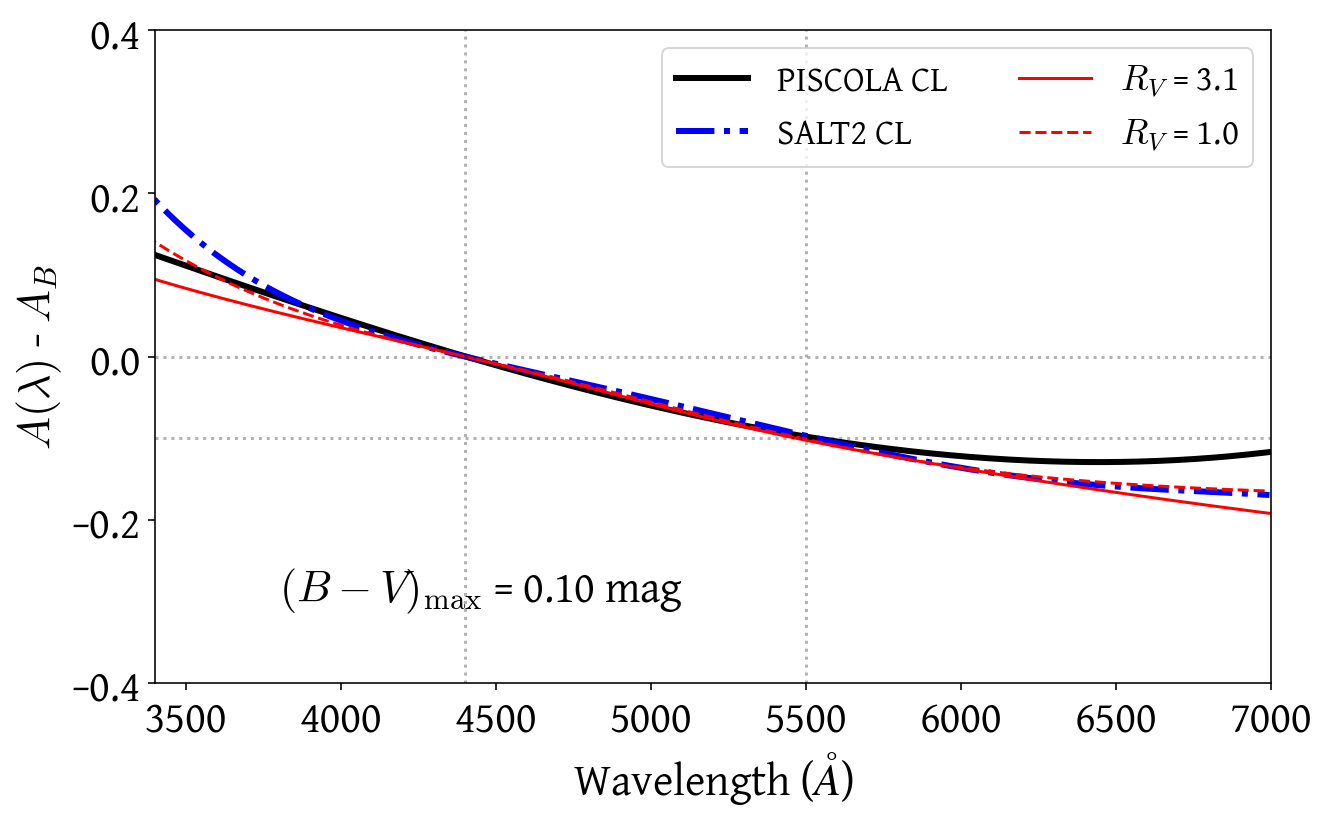

In [49]:
RV_list = [3.1,
           #2.0, 
           1.0] 
ls_list = ['-', 
           #'dotted', 
           '--']  # for the dust extinction laws
colour = 0.1

fig, ax = plt.subplots(figsize=(10, 6))

# colour laws
cl_poly = np.poly1d(mcmc_coefs)
ax.plot(WAVE, colour*cl_poly(WAVE), lw=3, color='k', label=f'PISCOLA CL')

salt2_cl_colour = (salt2_cl-salt2_ref)*colour
ax.plot(WAVE, salt2_cl_colour, label=f'SALT2 CL', lw=3, ls='-.', color='b')

# extinction law
for i, RV in enumerate(RV_list):
    AV = colour*RV 
    A_lambda = extinction_function(WAVE, EXT_LAW, AV, RV)
    A_ref = extinction_function(np.array([REF_WAVE]), EXT_LAW, AV, RV)

    ax.plot(WAVE, A_lambda-A_ref, label=f'$R_V$ = {RV}', color='r', ls=ls_list[i])

ax.axhline(0, ls='dotted', color='k', alpha=0.3)
ax.axhline(-colour, ls='dotted', color='k', alpha=0.3)
ax.axvline(B_WAVE, ls='dotted', color='k', alpha=0.3)
ax.axvline(V_WAVE, ls='dotted', color='k', alpha=0.3) 

ax.set_xlabel('Wavelength ($\AA$)', fontsize=22)
ax.set_ylabel(f'$A(\lambda)$ - $A_B$', fontsize=22)
ax.tick_params(labelsize=22)
ax.set_ylim(-0.4, 0.4)
ax.set_xlim(3400, 7000)
ax.legend(ncol=2, fontsize=18)


# set colour values
ax.text(3800, -0.3, r'$(B-V)_{\rm max}$ = %.2f mag'%colour, fontsize=22)

plt.savefig(f'plots/colour_law_comparison.{FORMAT}', bbox_inches='tight')
plt.show()

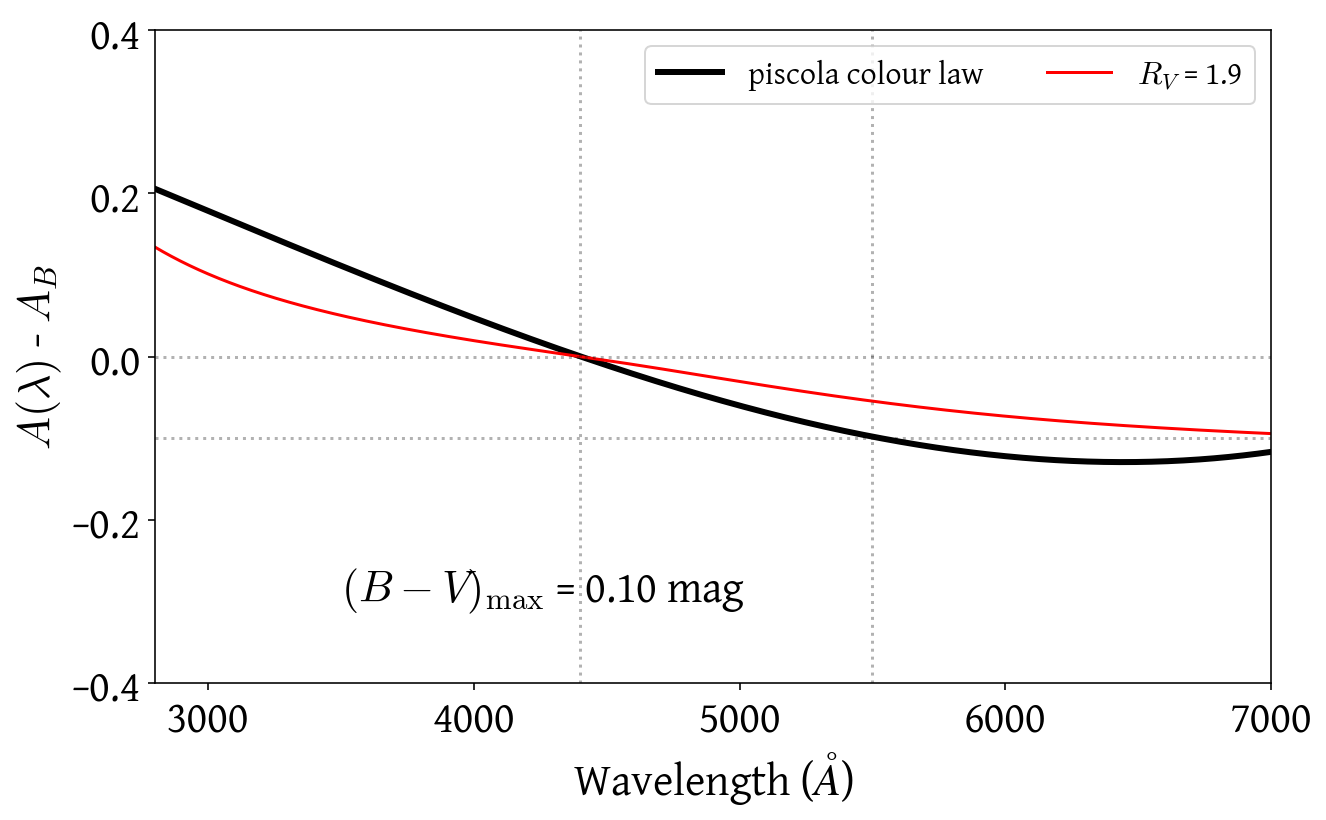

In [24]:
# optimize extinction law
y = colour*cl_poly(WAVE)
    
p0 = 3.1
args = (y, EXT_LAW, colour)
res = scipy.optimize.minimize(extinction_residual, p0, args=args)
RV_opt = res.x[0]

A_lambda_opt = extinction_function(WAVE, EXT_LAW, AV, RV_opt)
A_ref_opt = extinction_function(np.array([REF_WAVE]), EXT_LAW, AV, RV_opt)

#---------------------------------------
# plotting

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(WAVE, y, lw=3, color='k', label=f'piscola colour law')
ax.plot(WAVE, A_lambda_opt-A_ref_opt, label=f'$R_V$ = {RV_opt:.1f}', color='r')

ax.axhline(0, ls='dotted', color='k', alpha=0.3)
ax.axhline(-colour, ls='dotted', color='k', alpha=0.3)
ax.axvline(B_WAVE, ls='dotted', color='k', alpha=0.3)
ax.axvline(V_WAVE, ls='dotted', color='k', alpha=0.3) 

ax.set_xlabel('Wavelength ($\AA$)', fontsize=22)
ax.set_ylabel(f'$A(\lambda)$ - $A_B$', fontsize=22)
ax.tick_params(labelsize=22)
ax.set_ylim(-0.4, 0.4)
ax.set_xlim(2800, 7000)
ax.legend(ncol=3, fontsize=16)


# set colour values
ax.text(3500, -0.3, r'$(B-V)_{\rm max}$ = %.2f mag'%colour, fontsize=22)

#plt.savefig(f'plots/colour_law_dust_extinction_fit.{FORMAT}', bbox_inches='tight')
plt.show()

I get a value slightly larger than 1.